In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import math
#for removing warnings
import warnings

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = ds.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
uvar = ds.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
uv = ds.vel.isel(y=slice(900,1800), x=slice(200,1400))

In [11]:
# chooseing a level to look at 
level_list = [0, 7, 14, 20, 35, 39, 50,60]
depth_list = np.zeros(8)
for i, level in enumerate(level_list):
    depth = ds.depth[level].values
    depth_list[i] = depth
print(depth_list)

[5.05760014e-01 9.82275009e+00 3.08745613e+01 6.90216827e+01
 3.33862823e+02 5.08639893e+02 1.51636365e+03 3.13856494e+03]


In [12]:
'A funcktion for constructing PC ellipses at a given level '
def pc_ellipse(level, scale):
    
    dx = 20
    dy = 20
    jmax, imax = uv[0].shape
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)

    y = []
    x = []
    
    #ellipser:
    theta_l = []
    minor_l = []
    major_l = []
    #major_info = []
    
    indx =0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(uvar[level,:,:].values)
    vvar_depth = np.array(vvar[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)

    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
                [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                # Find and sort eigenvalues and eigenvectors into descending order
                values, vectors = np.linalg.eig(covm)
                order = values.argsort()[::-1]
                values, vectors = values[order], vectors[:, order]
                

                # center of ellipse
                y.append(uvy[j])
                x.append(uvx[i])

                # ellipser :
                major = np.sqrt(values[0])*scale
                minor = np.sqrt(values[1])*scale

                major_l.append(major)
                minor_l.append(minor)
                #major_info.append(values[0])

                # The anti-clockwise angle to rotate our ellipse by 
                vx, vy = vectors[:,0][0], vectors[:,0][1]
                theta = np.arctan2(vy, vx)*(180/math.pi)
                theta_l.append(theta)

                indx = indx + 1

    # converting to np.arrays
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
   
    return major_l, minor_l, theta_l, x, y

vomocrty and vozocrtx are measured in m/s. 
Take the variance of direction m.

 --> so majoraxis of sqrt(eigenvalue[0]) have PEV = eigenvalue[0]/tot.eiegenvalue --> tot.eienvalue=sigma(values)
 men dette gir jo meg ikke forholdet mellom de forskjellige ellipsene.. hmm 
 
 --> sier meg at gitte ellipse innerholder x% av variancen til strømmene på dette stedet over et år
 --> for holdet: regne ut PEV strøste sirkel og PEV minste og lage mean? 

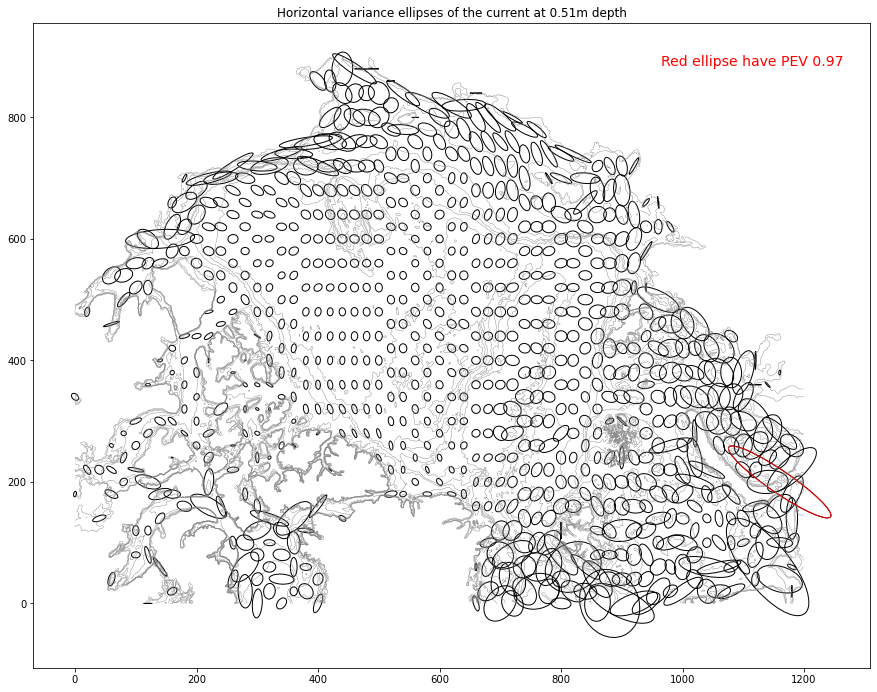

In [32]:
# Plot level 1
n = 0
s = 0.5e3 #stands for scale
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n], s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')
plt.show()

### Figure 1
Figure of the variance ellipser at a depth of 0.5m. 
The larges variation may be found in the Fram Strait, but the Barents Sea also have area with large spread in the currents directions. The variance crosses away from the boundaries are largly isotrop, but becomes more an-isotrop towards the Barents sea.
Only the variance ellipses adjacent to the boundaries is alligned with the topography.The variance ellipses on the shelf are largely an-isotrope with a tilt to the East of the topography.

## Note to myself
--> a small ellipse contains less information than a bigger ellipse, the more information the PC contains, the bigger the ellipse gets. So with shallow water, the distance to topography reduces, and the currents can feel it more, hence more of the currents will go in the same directions. \
--> with small ellipses most of the currents will be described by the ellipse, but also more of the currents will NOT be described by the ellipse \
--> Why do we then espect less variance with depth??? Because of friction? The velocity reduces so more of the currents are affected by eddies ? 

Figure of the PC at depth 0.5m depth. The PC crosses on the shelf are mostly an-isotrop, but still not alligned with the topography. The crosses are only allingned with the topography close to the boundaries. 
In the ocean basin the crosses are more ispotrope. The largest varaince can be found in Fram strait, but alos Bering stait and the Barents sea have larger variance. 

Figure of the PC at a depth of 0.5m. The PC crosses on the shelf are largely an-isotrope, tho they are not aligned with the topography.
Only the terrain adjacent to the boundaries is alligned with the crosses.
Crosses are more ispotrope in the ocean basin.
The most variation may be found in the Fram Strait, but the Bering Strait and the Barents Sea also have more. 

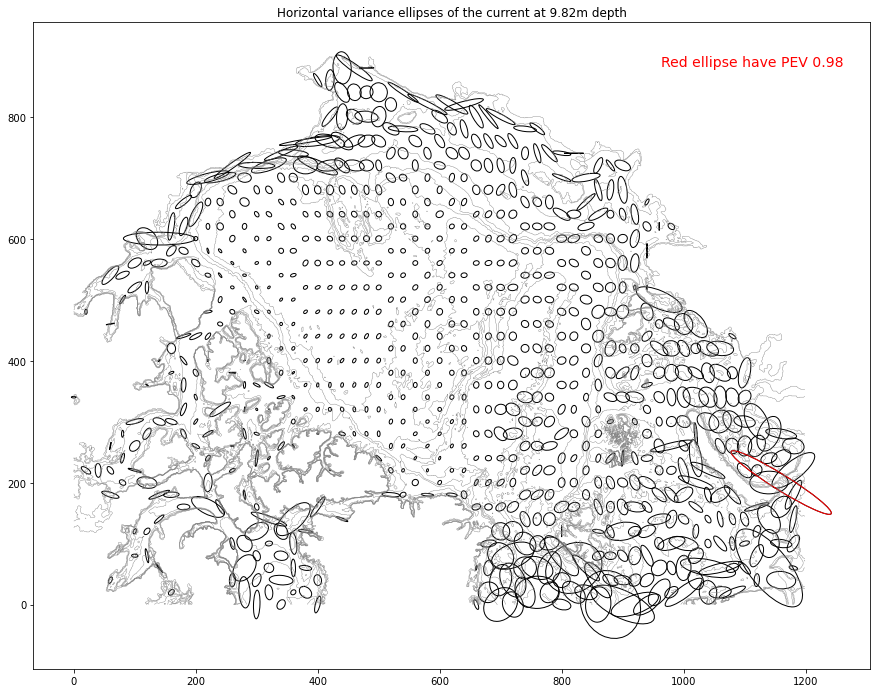

In [33]:
# Plot level 2
n = 1
s = 0.5e3
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n], s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')


### Figure 2
Figure of varaice ellipser at 10m depth. The variance in the middel of the basin have decreased from the surface. The variance ellipses at the shelt area are still towars the east, thus not alligned with topography as the varaince ellipses closer to the boundaries are. The larges sprad in the variance can still be found in the Barent sea or Fram strait. 

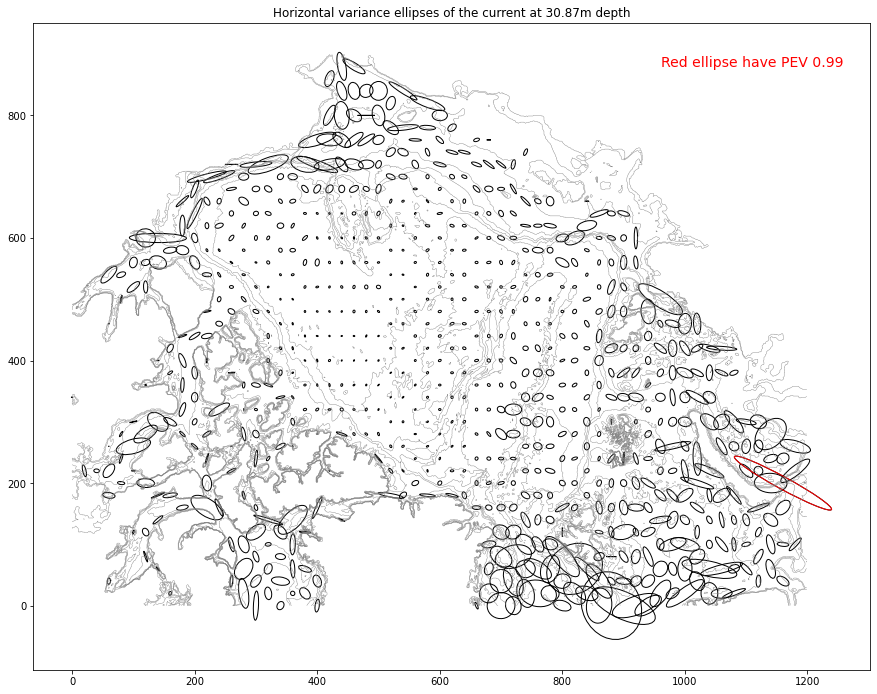

In [34]:
# Plot level 3
n = 2
s = 0.5e3
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n],s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')

### Figure 3
Variance ellipses at 30m depth. The variance in the midel of the basin, away from boundaries have significan reduced from the surface, but have also become less isotrop. Also on the shel can a stronger topographic signa be detected, where the varaince ellipses are now alligned with the topography on the shelf. The variance ellipses on the Western side of the Artic ocean, towards Canada, are also alligned with the topography, just smaller than those on the shelf. Thus, there are less variance in the currents on this side of the basin. 

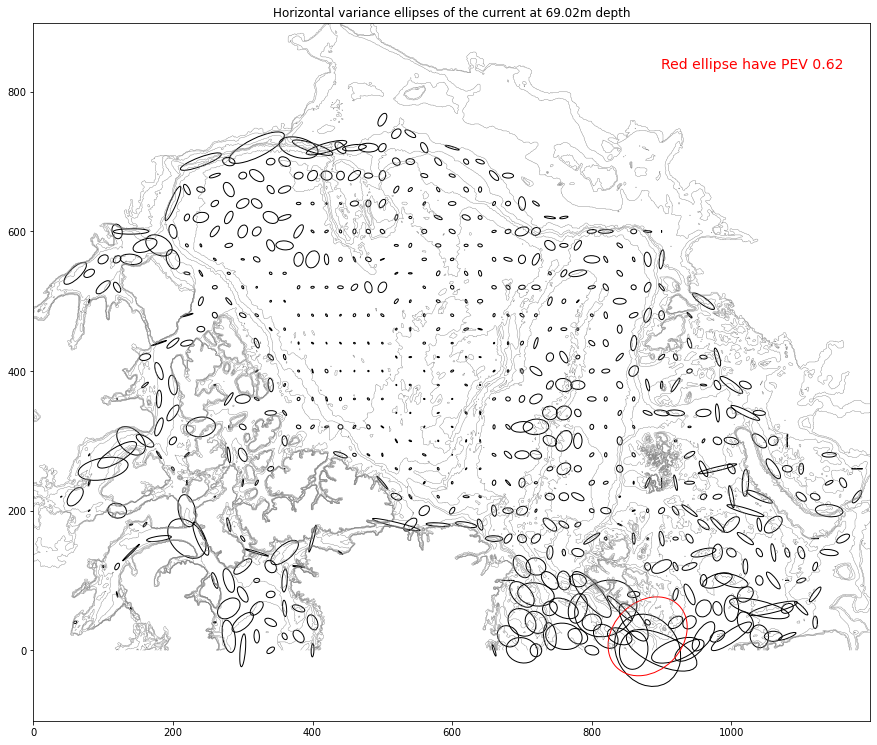

In [35]:
# Plot level 4
n = 3
s = 0.5e3
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n], s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')

### Figure 4
Variance ellipser at 70m depth. It is now easier to see that the currents follow the topography around the Arctic ocean. Areas with larger variance in the basin can be seen over Gakkel ridge, separating Amundsen and Nansen basin, and in Canda basin, between Baufort shelf and Chukchi plateau. 

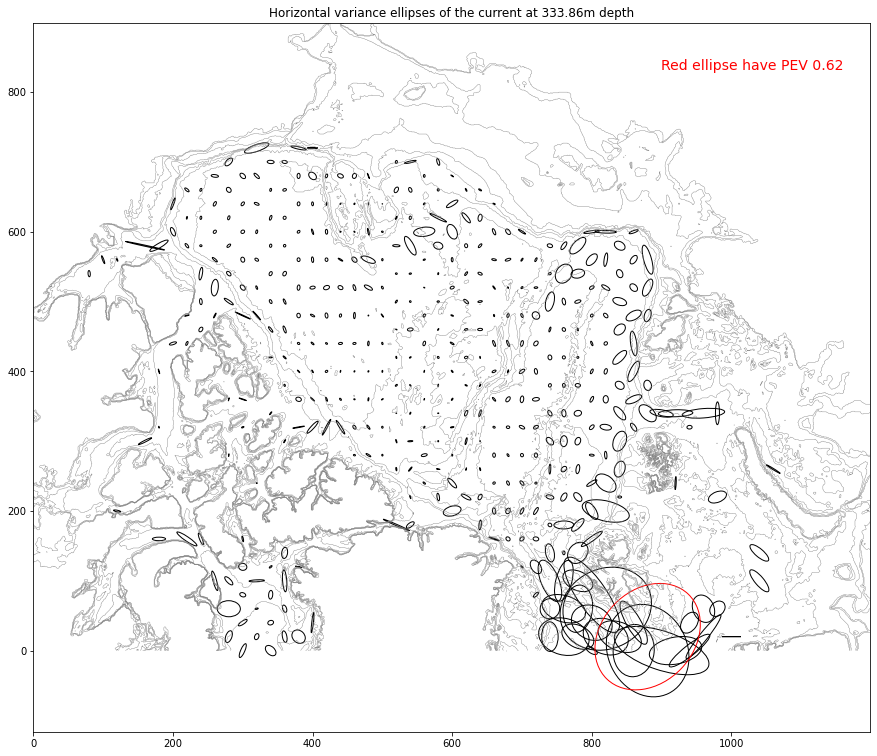

In [38]:
# Plot level 5
n = 4
s = 1e3
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n],s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')

### Figure 5
VAriance ellipser at 333m depth. Not much variance in the currents anymore, with thept the currents are more stabel, not much switching in direction, following the topography. 

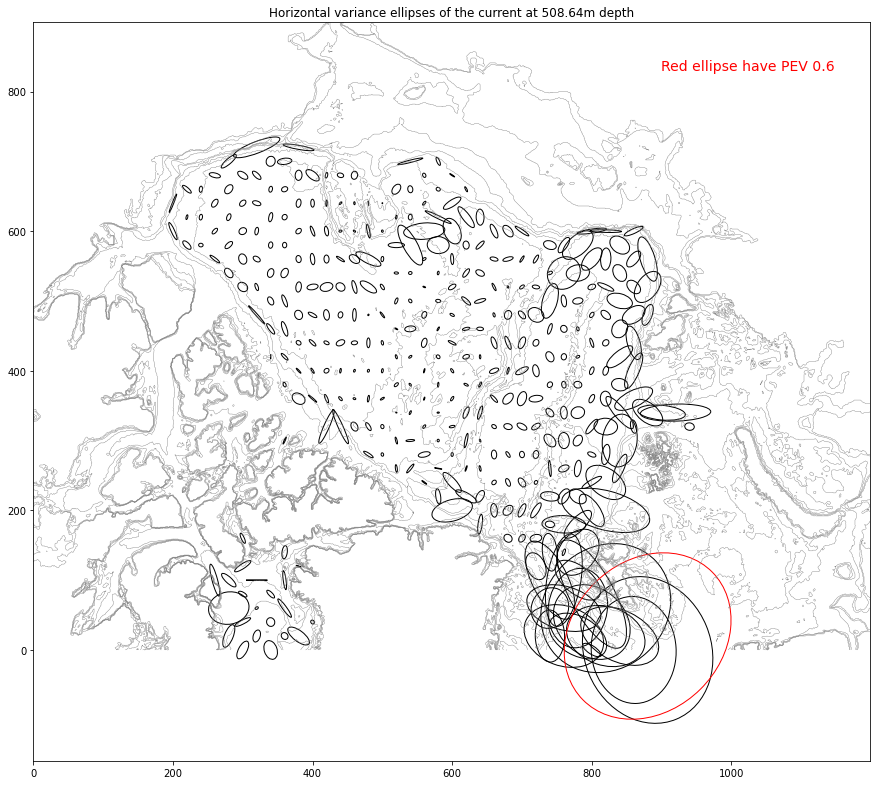

In [40]:
# Plot level 6
n = 5
s = 0.2e4
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n], s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')

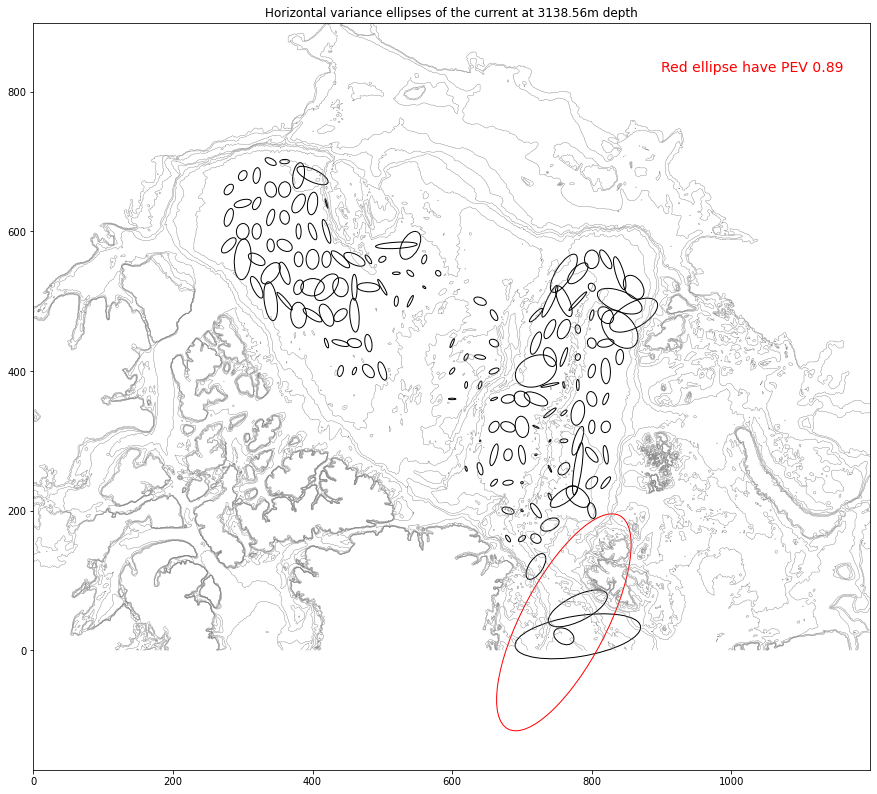

In [42]:
# Plot level 6
n = 7
s = 0.5e4
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n], s)

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'Horizontal variance ellipses of the current at ' 
          + str(round(depth_list[n],2)) 
          + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

'Getting the index to the largest variance ellipse'
vmax = max(maj_ax) 
index_max = maj_ax.index(vmax)
    
ellipse = Ellipse((x[index_max],y[index_max]), 
                      width = maj_ax[index_max]*2, 
                      height = min_ax[index_max]*2,
                      angle = angel[index_max],
                      facecolor = 'none',
                      edgecolor='r')
ax.add_patch(ellipse)


PVE = round(((maj_ax[index_max]**2)/s)/(((maj_ax[index_max]**2)/s)+((min_ax[index_max]**2)/s)),2) #hmm denne er feil.. 

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, f'Red ellipse have PEV {PVE}', color = 'r', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)


ax.set_aspect('equal')